## 1. Introduction

This dataset corresponds to an augmented version of the "Electrical Grid Stability Simulated Dataset", created by Vadim Arzamasov (Karlsruher Institut für Technologie, Karlsruhe, Germany) and donated to the University of California (UCI) Machine Learning Repository (link here), where it is currently hosted.

Two primary references support this development and demand special mention:

"Taming instabilities in power grid networks by decentralized control" (B. Schäfer, et al, The European Physical Journal, Special Topics, 2016, 225.3: 569-582), in which Dr. Schäfer (Network Dynamics, Max Planck Institute for Dynamics and Self-Organization - MPIDS, Göttingen, Germany) and his co-authors describe in detail the DSGC (Decentral Smart Grid Control) differential equation-based model to assess stability of smart grids;
"Towards Concise Models of Grid Stability" (V. Arzamasov, K. Böhm and P. Jochem, 2018 IEEE International Conference on Communications, Control, and Computing Technologies for Smart Grids (SmartGridComm), Aalborg, 2018, pp. 1-6), in which Dr. Arzamasov and his co-authors explore how data-mining techniques can address DSGC model simplifications.
The author is particularly thankful for Dr. Arzamasov's personal guidance and comments on the overall dataset structure.


### 1.1 Smart Grid Monitoring
As we are going through major energy transformation, swicthing from fosil fuels to renewable energies, power grid monitoring is facing increasingly complex paradigm change. Smart grid stability refers to the ability of a power grid to maintain continuous and reliable electricity supply even when facing various challenges like changes in demand, production, or external disruptions. Much of this monitoring system is fully automated, and to further increase the resilience of the smart grid system, we will try to use DL models to learn from the historical and predict the (in)stability of the power grid, before issues happen.


### 1.2 Decentralized Smart Grid Control (DSGC)
The DSGC system describes a distributed power system, where the decision making and facilitaion of the power grid are done locally, instead of via a central control system. This allows the power gird to 
1. Be more resilient to failures (one regional power grid failure won't affect the other regions, and can be compensated by enighboring grid). 
2. Improve response time (minimal delay between data collection and decison making).
3. Integrate and facilitate renewable energy more effectively (renewable energy source are often more scattered in terms of both space and time, fast fascillitation is often needed for adjusting grid loads or energy storage).

So we can think of the DSGC system as a large dynamic graph. Where power plants are connected to the regional consumers, local energy storage facilities, and each other.
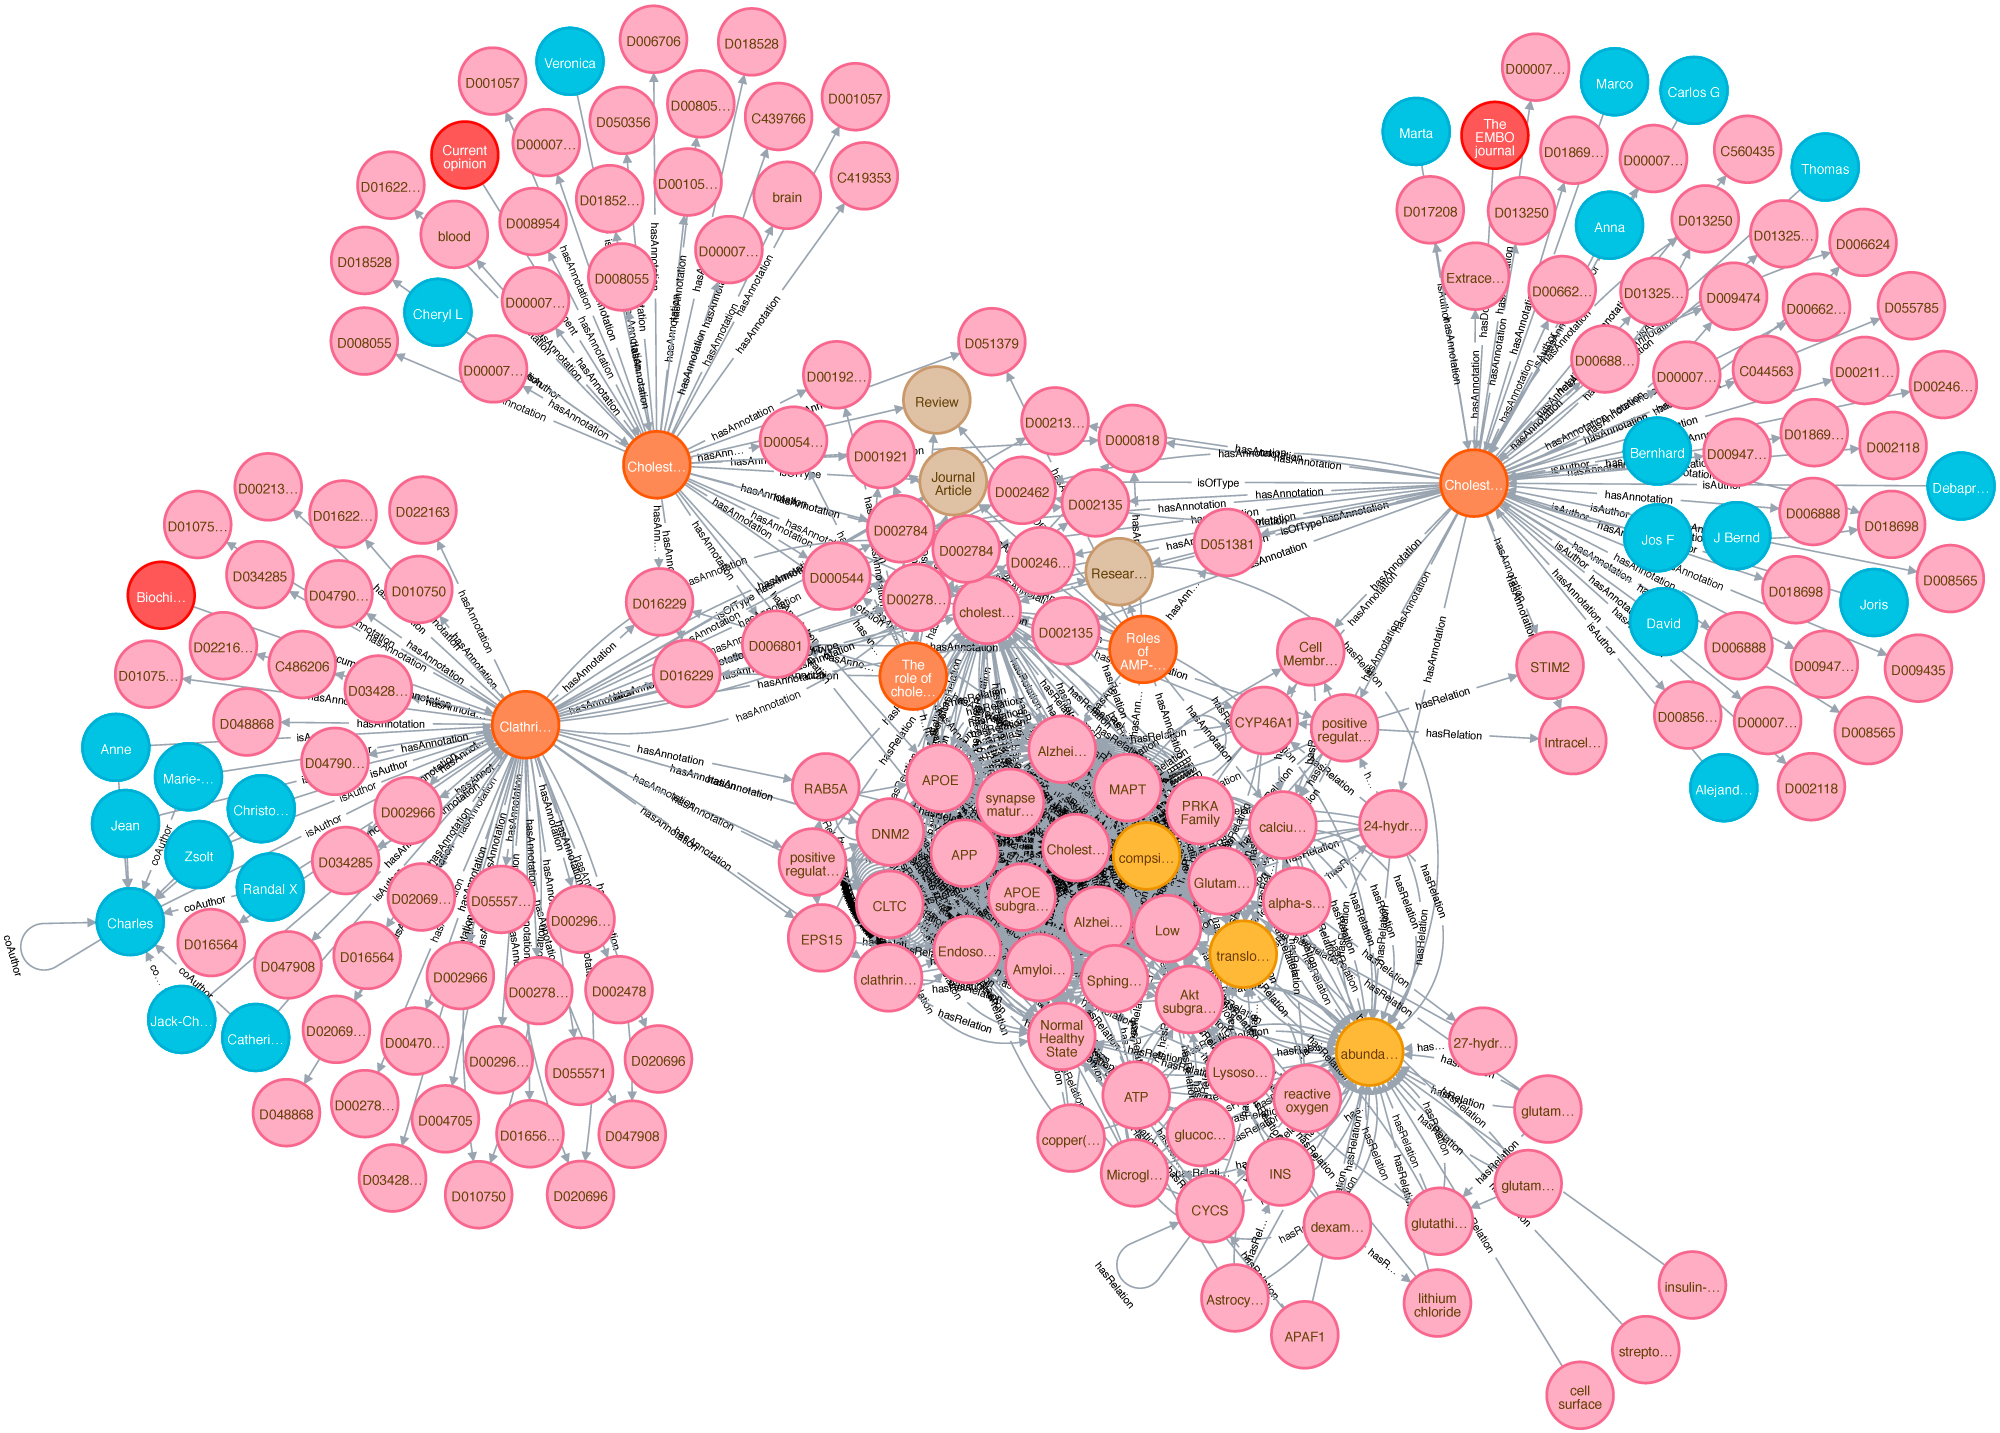
Moreover, a traditional power system in which power plants create and transfer enegergies for the consumers to use, is a 'unidirectional' system. Now, since many consumers can also produce energy with their own facilities (i.e. solar panels) and support it to the larger system, the energy flow is 'bidirectional'.


A simplified graph architecture is the 4-node star below.
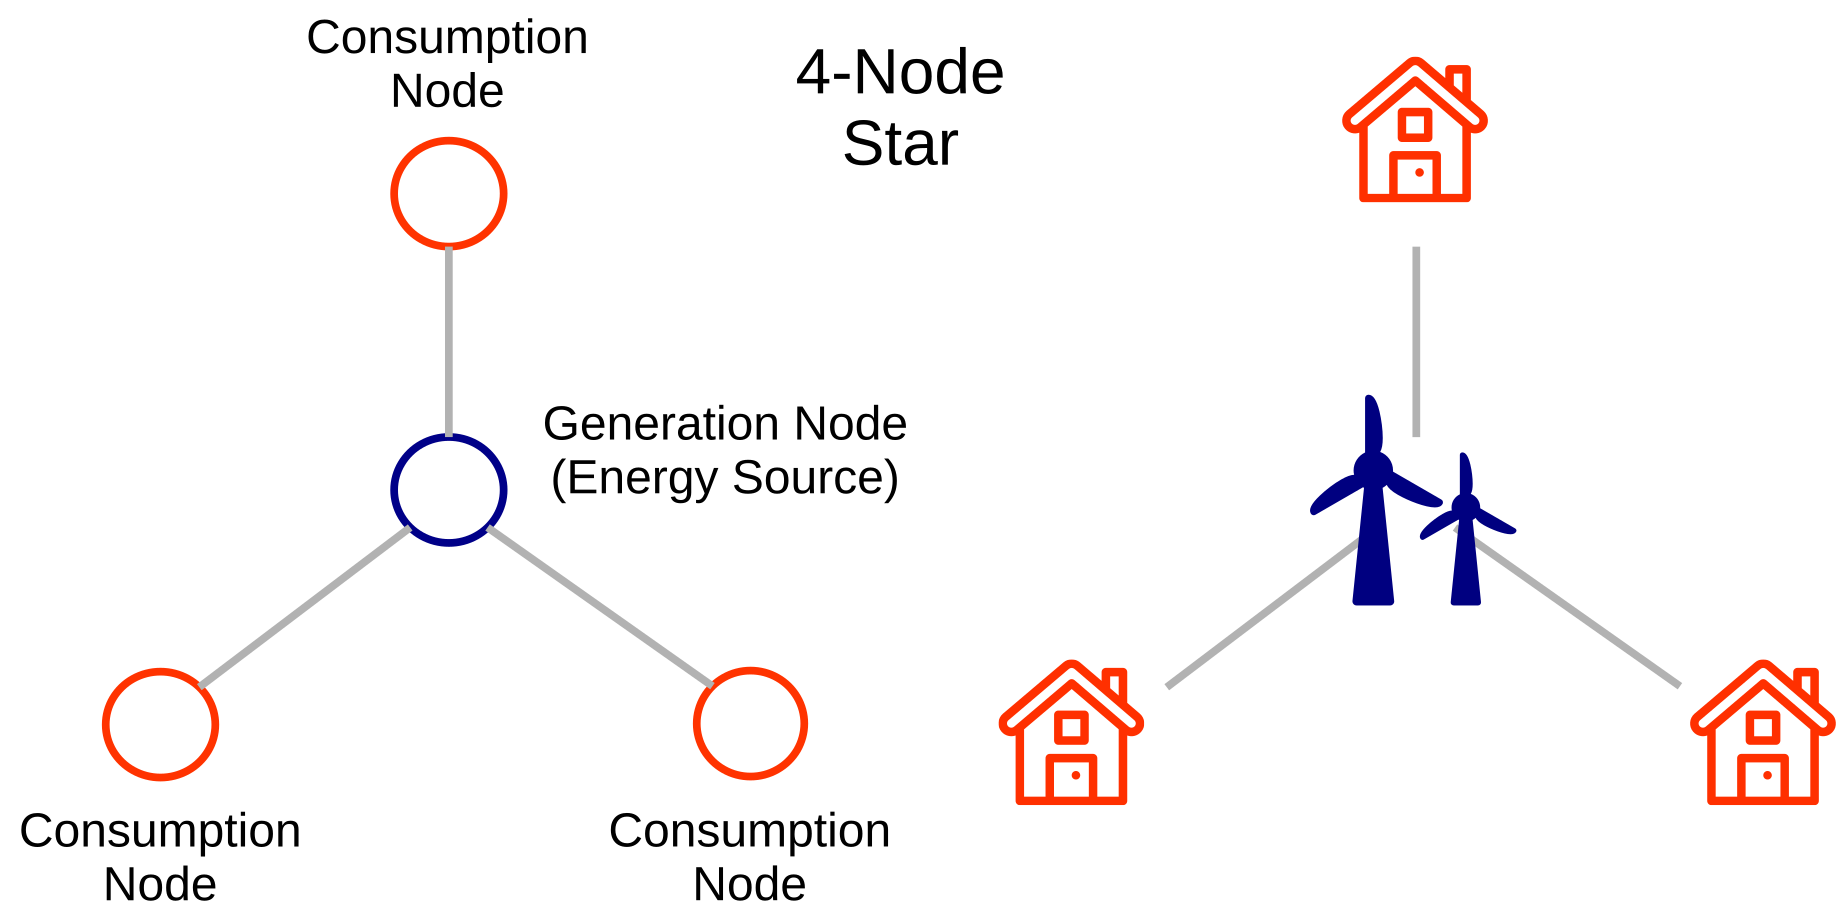
In which the central node is the power generation entity that supplies to three consumption nodes. The model takes into consideration inputs (features) related to:
1. Total Power Balance (In a stable grid, the power generated should equal the power consumed. Any mismatch can cause frequency fluctuations leading to instability.)
2. Response Time of Participants (This refers to how quickly the nodes, both generation and consumption, can adjust their power output or intake in response to changes in electricity prices. Faster response times can help stabilize the grid by quickly correcting imbalances.)
3. Energy Price Elasticity (This measures how sensitive the participants are to price changes. It impacts how effectively the grid can use pricing as a tool to balance supply and demand dynamically.)

### 1.3 Objective
This project aims to create DL model that can be used to predtict power gird (in)stability.

## 2. Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

2024-06-24 19:37:18.521280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 19:37:18.521422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 19:37:18.656370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 3. EDA

Now, as mentioned in notebook https://www.kaggle.com/code/pcbreviglieri/predicting-smart-grid-stability-with-deep-learning this is a synthetic dataset. The original dataset had 10000 observations, and 60000 after augmentation.

The dataset contains 12 primary predictive features and 2 dependent variables.

Predictive features:

'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');

Dependent variables:

'stab': the maximum real part of the characteristic differentia equation root (if positive, the system is linearly unstable; if negative, linearly stable);
'stabf': a categorical (binary) label ('stable' or 'unstable').
As there is a direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' will be dropped and 'stabf' will remain as the sole dependent variable.

As the dataset content comes from simulation exercises, there are no missing values. Also, all features are originally numerical, no feature coding is required. Such dataset properties allow for a direct jump to machine modeling without the need of data preprocessing or feature engineering.

In [2]:
df = pd.read_csv("/kaggle/input/smart-grid-stability/smart_grid_stability_augmented.csv")

### 3.1 Descriptive data 

In [3]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB


What a lovely sight, how amazing, the power of synthetic dataset. That being said, we should still conduct a thorough feature and correlation assessment.

### 3.2 Check the balance of the dependent variables

stabf
unstable    0.638
stable      0.362
Name: proportion, dtype: float64


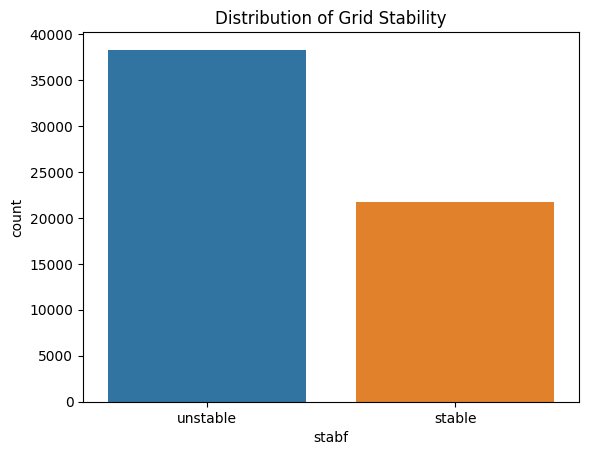

In [5]:
print(df['stabf'].value_counts(normalize=True))

# Visualize the distribution
sns.countplot(x='stabf', data=df)
plt.title('Distribution of Grid Stability')
plt.show()

### 3.3 Check the distribution of the perdictive features

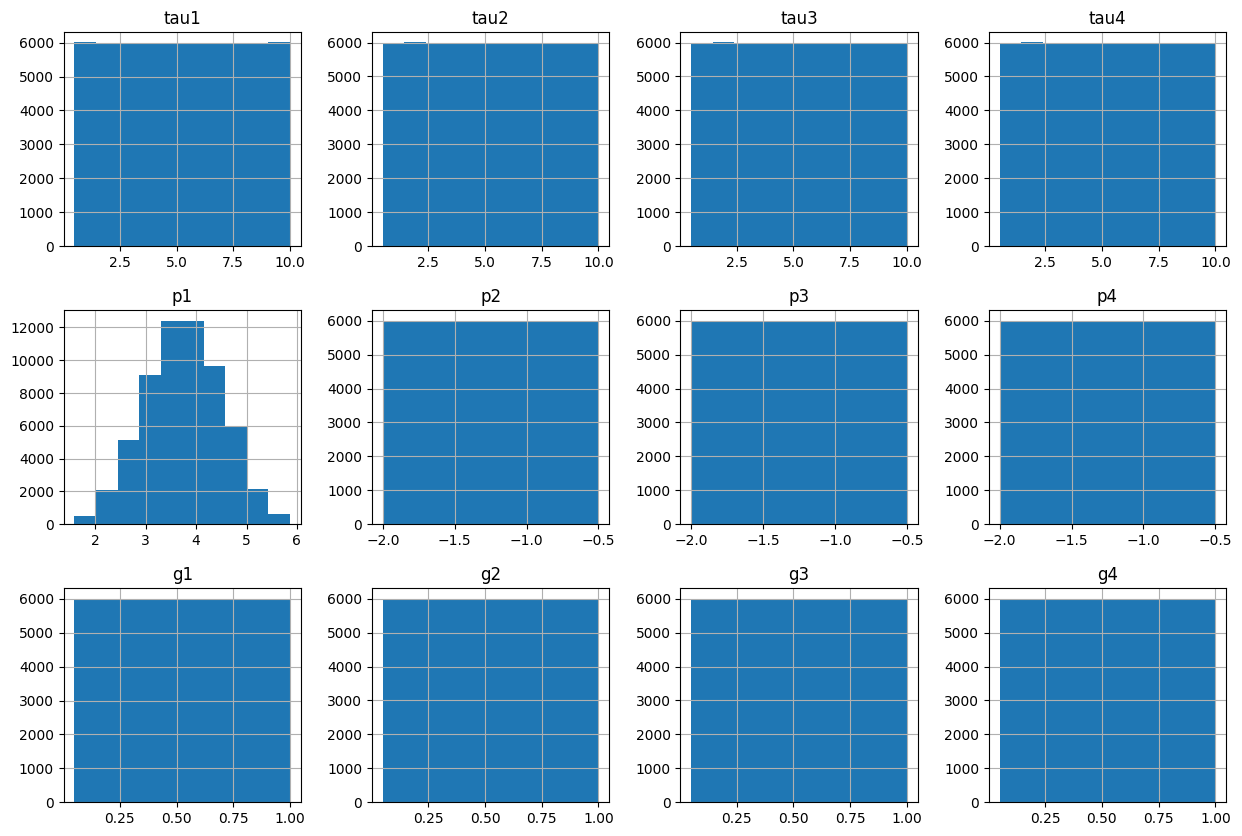

In [6]:
features = ['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4']
df[features].hist(figsize = (15, 10), layout = (3, 4))
plt.show()

Let's look at the histogram row by row.

Row 1 - Reaction time:
- tau1 to tau4 basically are all uniformly distributed. Indicating the reaction times are widely and evenly distributed from slow to fast.

Row 2 - Nominal power:
- p1 is the power produced by generation node, we can see it has a normal distribution, meaning the power generation output is relatively balanced, as any significant deviation from the central range would indicate instability.
- p2-p4 is power consumed by consumption nodes, the uniform distribution indicates consistent behavious within range. A key to undertsand the grid stability is to observe how well p2-p4 match with p1

Row 3 - Price elsticity coefficients:
- The price elasticity coefficients for g1-g4 seem to be uniformly distributed, this means  a uniform spread from low to high elasticity across all nodes.


### 3.4 Check correlation between features and dependent variables

Check for any significant correlations between features and with the dependent variable. This can help identify potential multicollinearity in our dataset.

In [7]:
# map stability label to float
df['stabf'] = df['stabf'].map({'stable': 0, 'unstable': 1})

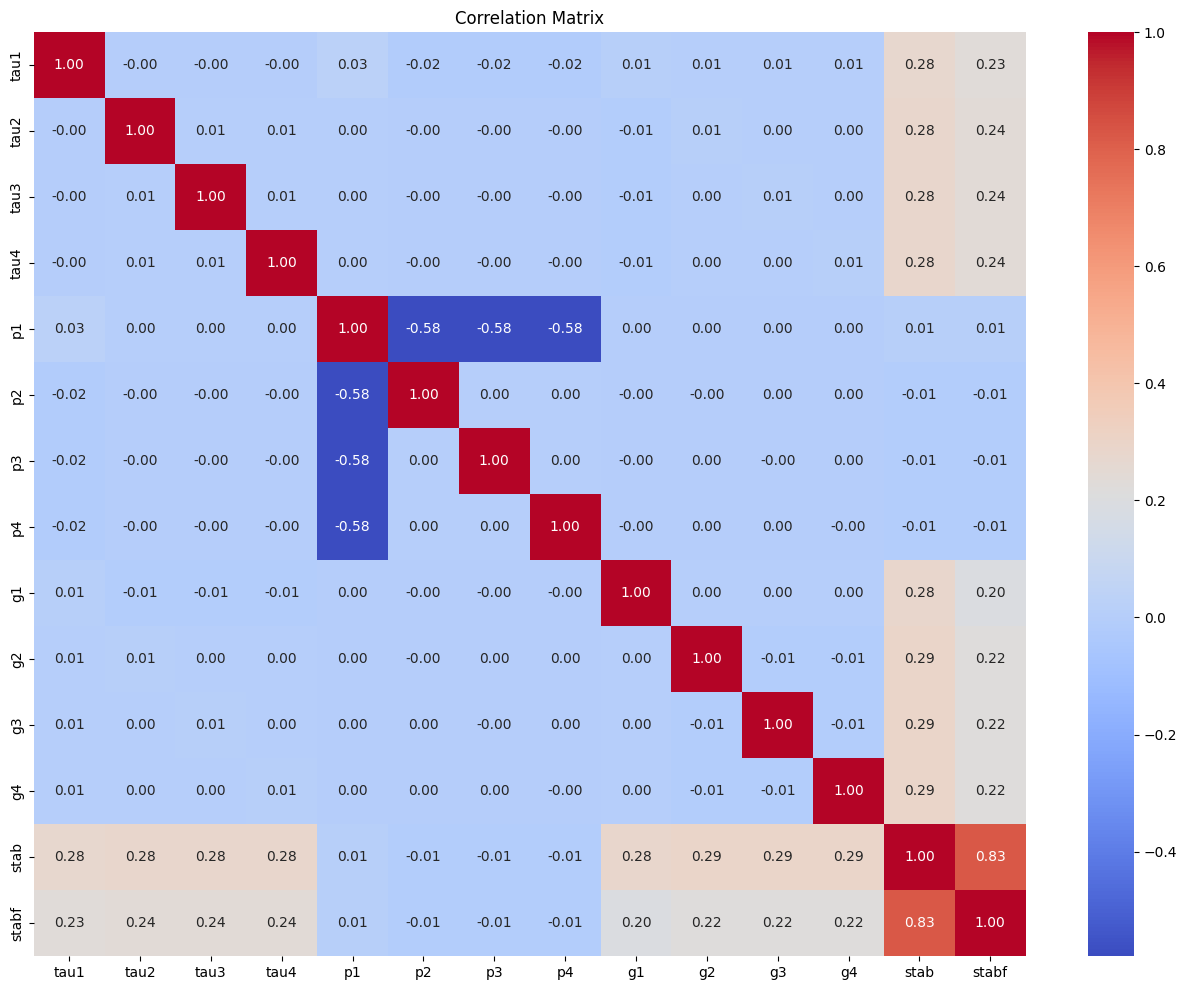

In [8]:
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

1. In the center of the plot we can observe a moderate to strong correlation between p1 and p2-4. This is expected as p1 = sum(p2, p3, p4).
2. At the bottom right corner, we can see a strong positive correlation between stab and stabf. This is becuase stabf is derived from stab. For our purpose, we can simply eliminate stab from our dataset.
3. Low correaltion between reaction time variables (tau1-4), nominal power (p1-4), and price elasticity (g1-4), indicates that these variables can independently contribute to the predictive model without redundancy.

In [9]:
# drop 'stab'
df = df.drop("stab", axis=1)

## 4. Preprocessing

Note that there is no missing value in the dataset and we have converted the target 'stabf' to numerical.

### 4.1 Scaling

Since the predictive features are all on different ranges, we have to transform them to a smilar scale for better model performance.

In [10]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

### 4.2 split dataset

Split our dataset into training and testing set at 80/20.

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(['stabf'], axis=1)
y = df['stabf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
# check if the training label distribution is consistent with the original dataset
print(y_train.value_counts(normalize=True))

stabf
1    0.638208
0    0.361792
Name: proportion, dtype: float64


## 5. Building DL model

We will use a straught forward model architecture to begin with. The model will have 
1. An input layer with 12 nodes
2. Three hidden layers with 24, 24, 12 nodes
3. One output layer

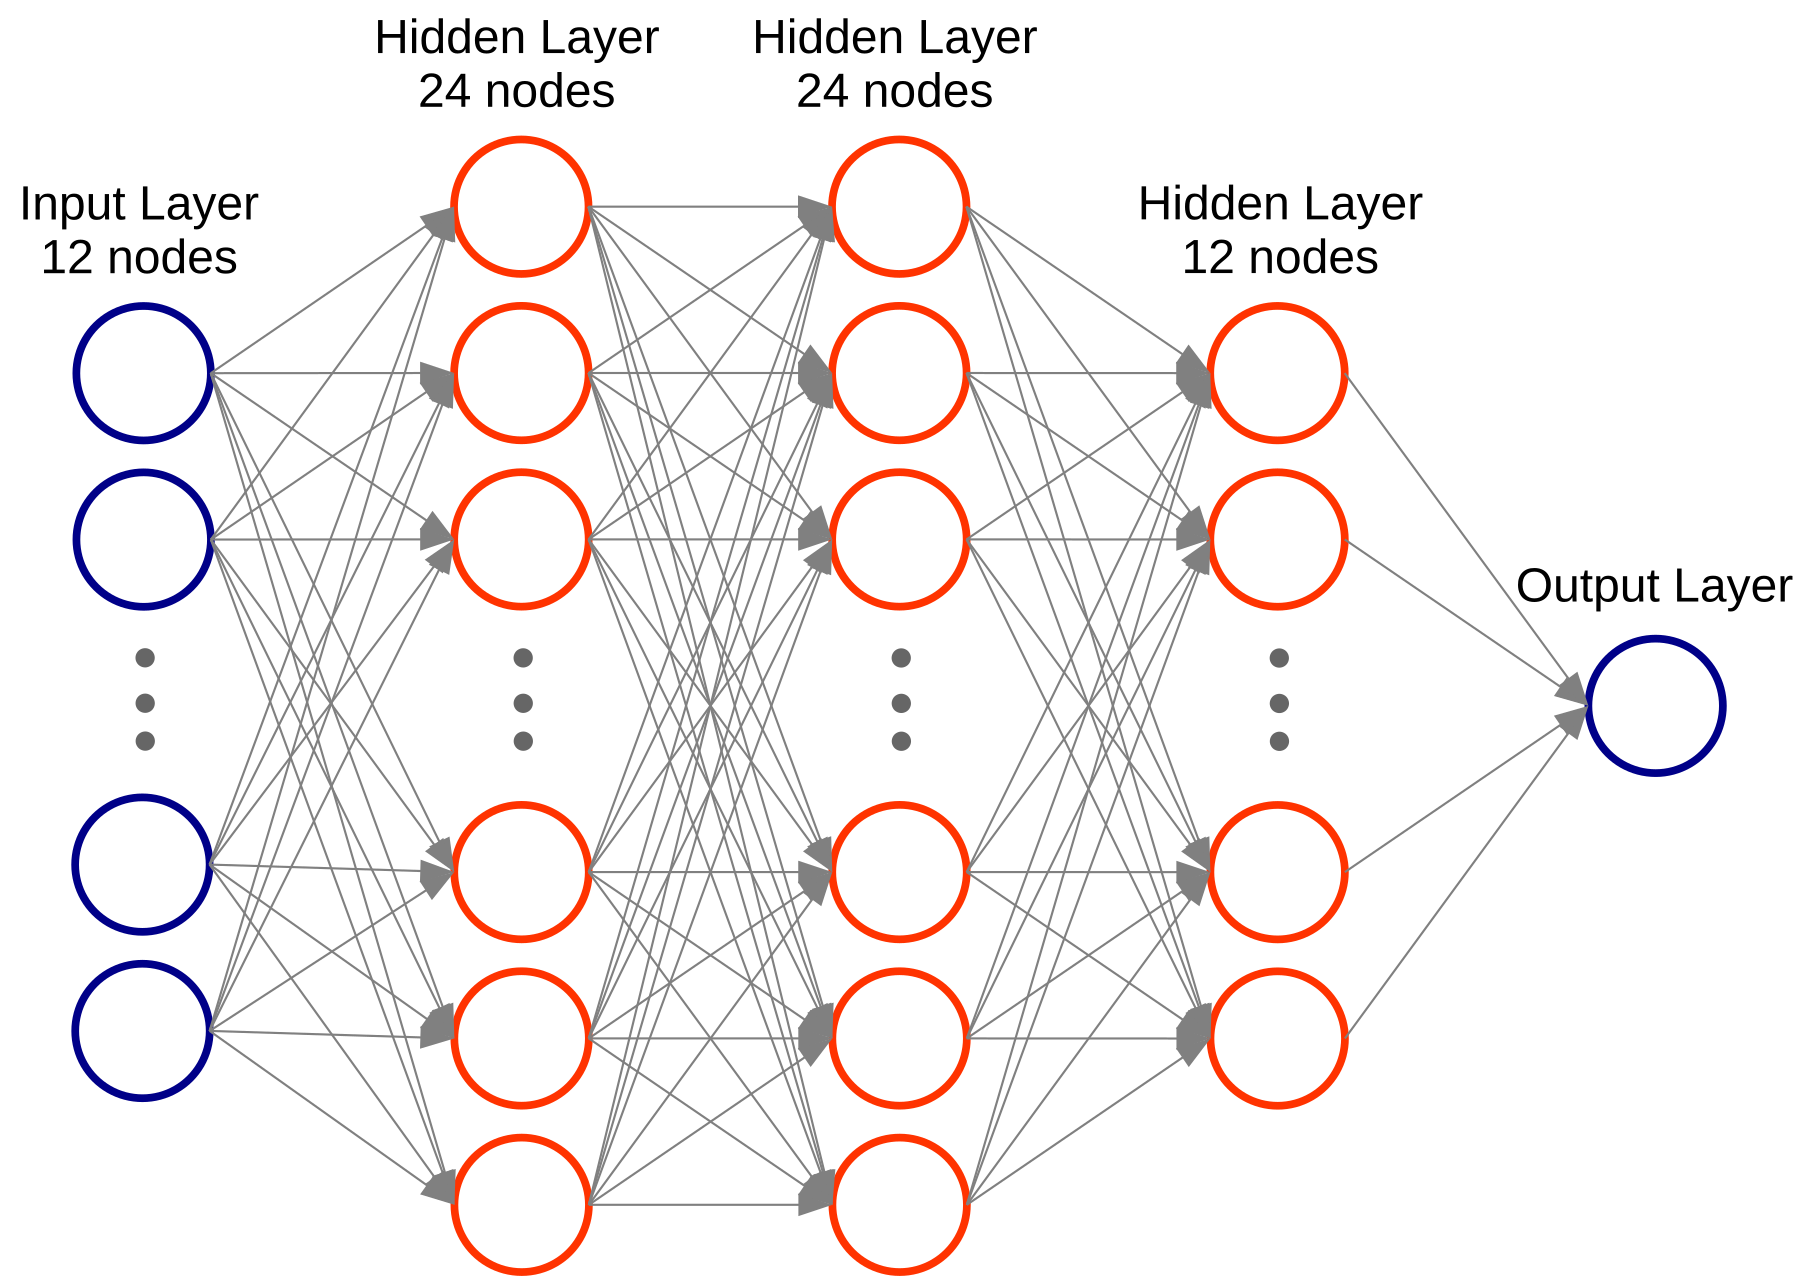

We may adjust the hyperparameter and model structure later as we see fit.

In [13]:
# innitialze the model
model = Sequential()

# Input layer and 1st hidden layer
model.add(Dense(units=24, activation='relu'))

# 2nd hidden layer
model.add(Dense(units=24, activation='relu'))

# 3rd hidden layer
model.add(Dense(units=12, activation='relu'))

# output layer
model.add(Dense(units=1, activation='sigmoid'))

In [14]:
# compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
)

In [15]:
# train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7668 - loss: 0.4501 - val_accuracy: 0.9094 - val_loss: 0.2117
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9229 - loss: 0.1812 - val_accuracy: 0.9391 - val_loss: 0.1440
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9451 - loss: 0.1315 - val_accuracy: 0.9502 - val_loss: 0.1201
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9530 - loss: 0.1122 - val_accuracy: 0.9527 - val_loss: 0.1129
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9604 - loss: 0.0975 - val_accuracy: 0.9588 - val_loss: 0.1018
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9618 - loss: 0.0916 - val_accuracy: 0.9609 - val_loss: 0.0931
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9661 - loss: 0.0830 - val_accuracy: 0.9618 - val_loss: 0.0899
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9659 - loss: 0.0791 - 

<Axes: >

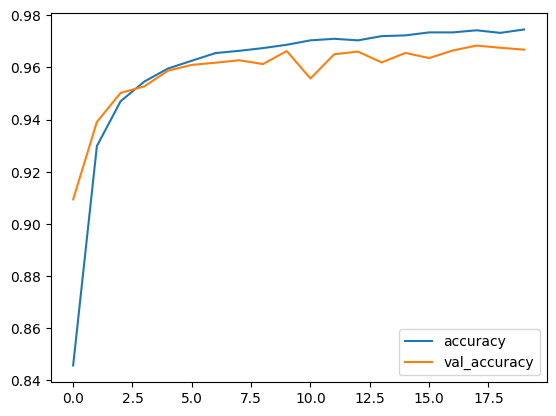

In [16]:
hist_df =pd.DataFrame(history.history)
hist_df.drop(columns=['loss', 'val_loss'], inplace=True)
hist_df.plot()

The validation accuracy of model converged around the 4th or 5th epochs and increased steadily. I think the current model is working fine, but I'd still try add dropout layer and see if that changes anything.

In [17]:
# innitialze the model
model2 = Sequential()

# Input layer and 1st hidden layer
model2.add(Dense(units=24, activation='relu'))
model2.add(Dropout(0.2))

# 2nd hidden layer
model2.add(Dense(units=24, activation='relu'))
model2.add(Dropout(0.2))

# 3rd hidden layer
model2.add(Dense(units=12, activation='relu'))
model2.add(Dropout(0.2))

# output layer
model2.add(Dense(units=1, activation='sigmoid'))

In [18]:
# compile the model
model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
)

In [19]:
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7328 - loss: 0.5223 - val_accuracy: 0.8717 - val_loss: 0.3032
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8574 - loss: 0.3280 - val_accuracy: 0.9172 - val_loss: 0.2077
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8917 - loss: 0.2585 - val_accuracy: 0.9339 - val_loss: 0.1715
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9043 - loss: 0.2344 - val_accuracy: 0.9372 - val_loss: 0.1615
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9135 - loss: 0.2168 - val_accuracy: 0.9388 - val_loss: 0.1575
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9128 - loss: 0.2108 - val_accuracy: 0.9398 - val_loss: 0.1481
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9215 - loss: 0.1933 - val_accuracy: 0.9399 - val_loss: 0.1478
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9230 - loss: 0.1915 - 

<Axes: >

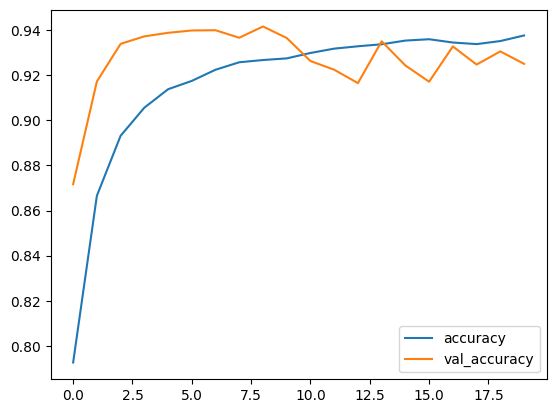

In [20]:
hist2_df =pd.DataFrame(history2.history)
hist2_df.drop(columns=['loss', 'val_loss'], inplace=True)
hist2_df.plot()

Interestingly, in the 2nd model the training accuracy had decreased while the validation accuracy remained to be on the same level. Let's evaluate both models.

In [21]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test)

print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy2*100:.2f}%")

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9658 - loss: 0.0765
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9291 - loss: 0.1563
Test accuracy: 96.61%
Test accuracy: 92.81%


## 6. Conclusion 

1. In the end our deep learning prediction models have yielded pretty decent results, with 97.12% and 93.68% test accuracy. 

2. Interestingly, we observed the negative effect of adding dropout regularization to our model. This may be due to the rather simple model structure, and not so large dataset. We can further change the dropout rate to see how that affects the model.

3. The models performance have been steadily increasing with the number of epochs and had not diverged up to 20 epochs. We can increase the number of epochs in future training and use checkpoints to find the best weights for the model.

4. It must be noted that input parameters utilized in the original DSGC simulations fall within predetermined ranges. As a follow-up step, it would be interesting to assess the model performance using a new test set with observations obtained in other alternative ranges.